In [4]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import copy

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from model_fitting import initialize_fitting
from utils import roi_utils

In [2]:
device = torch.device('cpu:0')

In [5]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [6]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [39]:
# Load results of the fitting procedure

subject = 1


fitting_type1 = 'texture_ridge_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations'
name1 = 'complex only, ridge'

fitting_type2 = 'texture_OLS_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations'
name2 = 'complex only, OLS'

# fitting_type1 = 'texture_ridge_8ori_4sf_no_crosscorrelations'
# name1 = fitting_type1

# fitting_type2 = 'texture_ridge_8ori_4sf'
# name2 = fitting_type2

# fitting_type1 = 'texture_ridge_8ori_4sf_no_autocorrelations'
# fitting_type1 = 'simple_complex_ridge_8ori_4sf'
# fitting_type1 = 'gabor_ridge_8ori_3sf'
# fitting_type2 = 'gabor_combinations_ridge_8ori_3sf'
# fitting_type1 = 'gabor_ridge_36ori_12sf'
# fitting_type2 = 'gabor_PCA_36ori_12sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))

# load first type of fitting
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type1)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1]

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('\nloading from %s\n'%fullfile2load)

out1 = torch.load(fullfile2load)
print(out1.keys())

# load second type of fitting (to compare)
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type2)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1]

# most_recent_date = 'Jul-06-2021_0356'

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('\nloading from %s\n'%fullfile2load)

out2 = torch.load(fullfile2load)
print(out2.keys())


loading from /user_data/mmhender/imStat/model_fits/S01/texture_ridge_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations/Jul-13-2021_1246/all_fit_params

dict_keys(['feature_table_simple', 'sf_tuning_masks_simple', 'ori_tuning_masks_simple', 'cyc_per_stim_simple', 'orients_deg_simple', 'orient_filters_simple', 'feature_table_complex', 'sf_tuning_masks_complex', 'ori_tuning_masks_complex', 'cyc_per_stim_complex', 'orients_deg_complex', 'orient_filters_complex', 'aperture', 'aperture_rf_range', 'models', 'include_autocorrs', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'val_cc_partial', 'val_r2_partial', 'features_each_model_val', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'padding_mode', 'n_prf_sd_out', 'autocorr_output_pix', 'debug', 'up_to_sess', 'shuff_rnd_seed'])

loading from /user_data/mmhender/imStat/mo

In [12]:
out2['up_to_sess']

1

In [8]:
subfolder2load

'/user_data/mmhender/imStat/model_fits/S01/texture_ridge_8ori_4sf/Jul-13-2021_1241'

In [40]:
# Pulling out useful elements from the saved data

voxel_mask = out1['voxel_mask']
brain_nii_shape = out1['brain_nii_shape']
voxel_idx = out1['voxel_index'][0]
voxel_roi = out1['voxel_roi']
if len(voxel_roi)==2:
    [roi_labels_retino, roi_labels_categ] = copy.deepcopy(voxel_roi)
    roi_labels_retino = roi_labels_retino[voxel_idx]
    roi_labels_categ = roi_labels_categ[voxel_idx]
    
assert(np.all(voxel_mask==out2['voxel_mask']))
assert(np.all(brain_nii_shape==out2['brain_nii_shape']))
assert(np.all(voxel_idx==out2['voxel_index']))
assert(np.all(voxel_roi[0]==out2['voxel_roi'][0]))
assert(np.all(voxel_roi[1]==out2['voxel_roi'][1]))


val_cc1 = out1['val_cc']
val_r2_1 = np.sign(val_cc1)*val_cc1**2
best_params1 = out1['best_params']
best_losses1 = out1['best_losses']
if 'best_lambdas' in out1.keys():
    best_lambdas1 = out1['best_lambdas']
else:
    best_lambdas1 = None
if 'lambdas' in out1.keys():
    lambdas1 = out1['lambdas']
else:
    lambdas1 = None

val_cc2 = out2['val_cc']
val_r2_2 = np.sign(val_cc2)*val_cc2**2
best_params2 = out2['best_params']
best_losses2 = out2['best_losses']
if 'best_lambdas' in out2.keys():
    best_lambdas2 = out2['best_lambdas']
else:
    best_lambdas2 = None
if 'lambdas' in out2.keys():
    lambdas2 = out2['lambdas']
else:
    lambdas2 = None

# also listing roi names here
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
n_rois = len(group_names)


In [23]:
out1['features_each_model_val']

In [20]:
out2['up_to_sess']

1

Text(0.5, 1.0, 'S01, complex only, OLS')

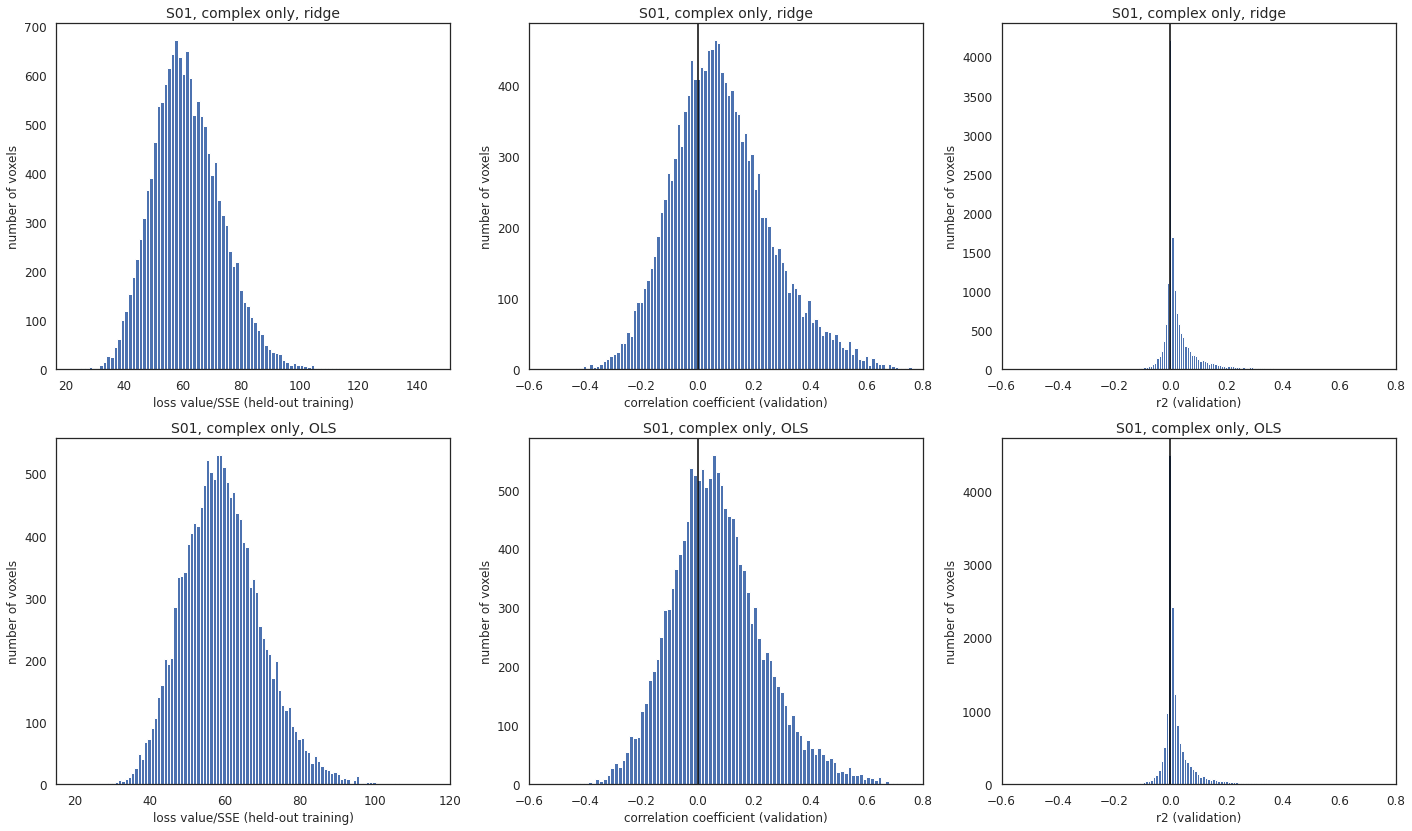

In [41]:
# Plot summary of performance
loss_lims = [15,120]
# loss_lims = [500,2000]
plt.figure(figsize=(24,14));

plt.subplot(2,3,1)
plt.hist(best_losses1,100)
# plt.xlim(loss_lims)
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, name1))

plt.subplot(2,3,2)
plt.hist(val_cc1,100)
plt.xlim([-0.6, 0.8])
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')
plt.title('S%02d, %s'%(subject, name1))

plt.subplot(2,3,3)
plt.hist(val_r2_1,100)
plt.xlim([-0.6, 0.8])
plt.axvline(0,color='k')
plt.xlabel('r2 (validation)');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject,  name1))

plt.subplot(2,3,4)
plt.hist(best_losses2,100)
plt.xlim(loss_lims)
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, name2))

plt.subplot(2,3,5)
plt.hist(val_cc2,100)
plt.xlim([-0.6, 0.8])
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')
plt.title('S%02d, %s'%(subject, name2))

plt.subplot(2,3,6)
plt.hist(val_r2_2,100)
plt.xlim([-0.6, 0.8])
plt.axvline(0,color='k')
plt.xlabel('r2 (validation)');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, name2))


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if sys.path[0] == '':


Text(0.5, 1.0, 'S01, texture_OLS_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations')

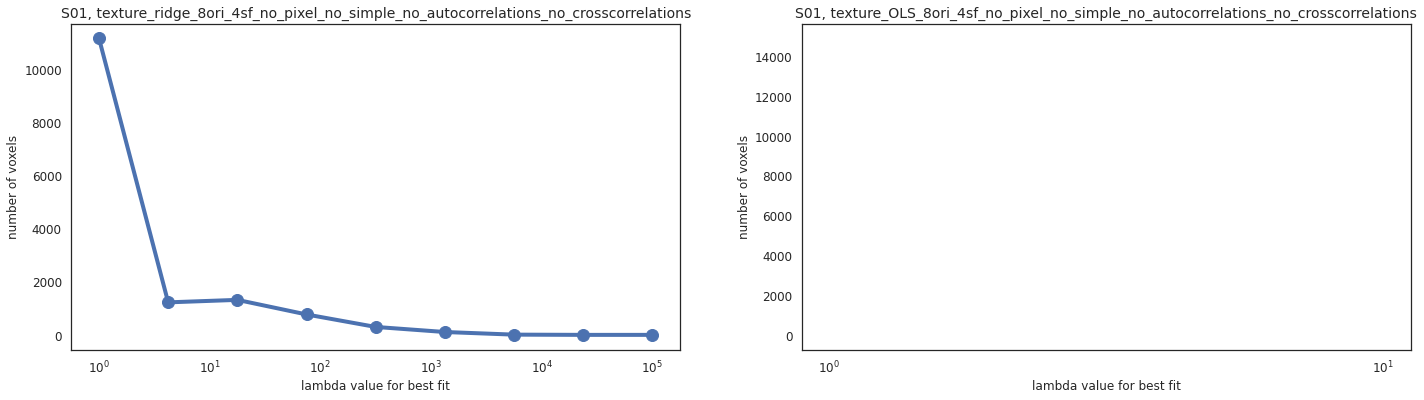

In [42]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
plt.plot(lambdas1, [np.sum(best_lambdas1==k) for k in range(len(lambdas1))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type1))

plt.subplot(1,2,2)
plt.plot(lambdas2, [np.sum(best_lambdas2==k) for k in range(len(lambdas2))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type2))

In [43]:
# Gather text labels for all ROIs

nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
ret, face, place = roi_utils.load_roi_label_mapping(nsd_root, subject, verbose=True)
max_ret_label = np.max(ret[0])
face[0] = face[0]+max_ret_label
max_face_label = np.max(face[0])
place[0] = place[0]+max_face_label
print(face)
print(place)
print(np.unique(roi_labels_categ))

ret_group_names = roi_utils.ret_group_names
ret_group_inds =  roi_utils.ret_group_inds
n_rois_ret = len(ret_group_names)

categ_group_names = list(np.concatenate((face[1], place[1])))
categ_group_inds =  list(np.concatenate((face[0], place[0])))
n_rois_categ = len(categ_group_names)

n_rois = n_rois_ret + n_rois_categ

[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
[1, 2, 3, 4, 5]
['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
[1, 2, 3]
['OPA', 'PPA', 'RSC']
[array([26, 27, 28, 29, 30]), ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']]
[array([31, 32, 33]), ['OPA', 'PPA', 'RSC']]
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]


Text(0.5, 0.98, 'Correlation coef. on validation set\nS01\ncomplex only, ridge (x axis) vs complex only, OLS (y axis)')

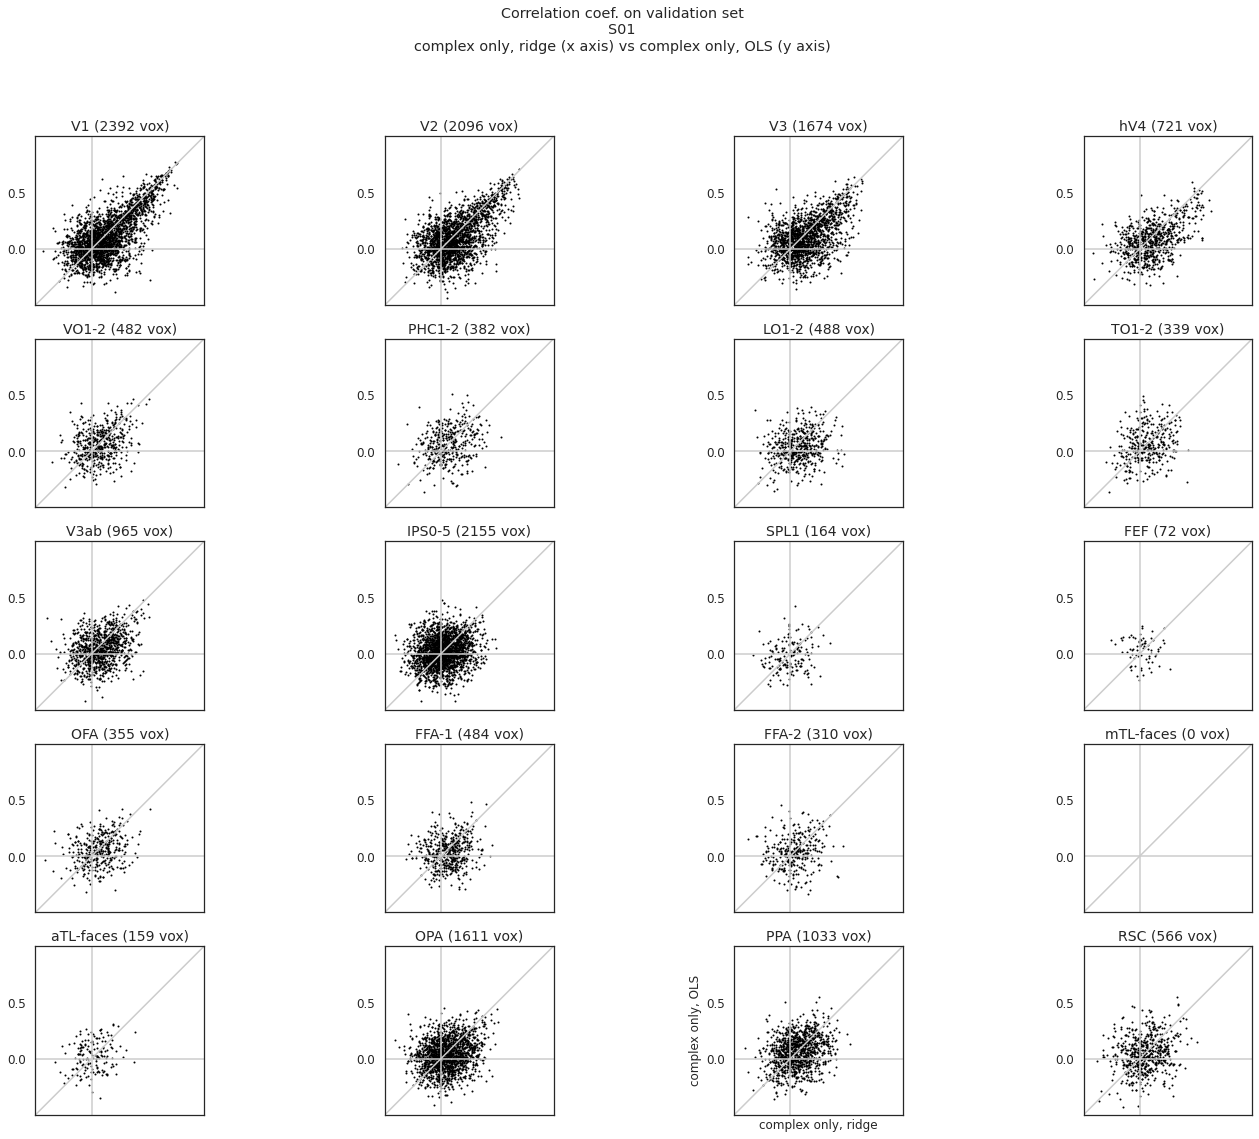

In [44]:
# Plot correlation coefficient for each ROI separately.

cclims = [-0.5, 1]
plt.figure(figsize=(24,18))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    plt.subplot(npx,npy,rr+1)

    vals1 = val_cc1[inds_this_roi]
    vals2 = val_cc2[inds_this_roi]

    plt.plot(vals1, vals2,'.',color='k',markersize=2)
    plt.axis('square')
    plt.xlim(cclims)
    plt.ylim(cclims)
    plt.xticks([0,0.5])
    plt.yticks([0,0.5])
    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.axvline(0,color=[0.8, 0.8, 0.8])
    plt.plot(cclims, cclims,color=[0.8, 0.8, 0.8])
    if rr==n_rois-2:
        plt.xlabel(name1)
        plt.ylabel(name2)
    plt.xticks([])
    
    plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d\n%s (x axis) vs %s (y axis)'%(subject, name1, name2))